<a href="https://colab.research.google.com/github/chellick/Super_resolution/blob/main/simplelines_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import cv2
import os
import sys
from PIL import Image, ImageDraw
import random

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
image = Image.new('RGB', (100, 100), 'black')
image.save("drive/MyDrive/Colab Notebooks/datasets/simplelines/main.png")

In [ ]:
def create_dataset(size):
    for i in range(size):
        with Image.open("drive/MyDrive/Colab Notebooks/datasets/simplelines/main.png") as im:
            draw = ImageDraw.Draw(im)
            draw.line(((0, random.randint(1, im.size[0])), (random.randint(1, im.size[1]), 0)) + im.size, width=2, fill=128)
            hr = im
            hr.save(f"drive/MyDrive/Colab Notebooks/datasets/simplelines/hr/{i}.png")


create_dataset(1000)

In [ ]:
os.listdir('drive/MyDrive/Colab Notebooks/datasets/simplelines')

['script.py', 'hr', 'main.png']

In [ ]:
data_path = 'drive/MyDrive/Colab Notebooks/datasets/simplelines/'

In [ ]:
def load_data(name, path):
    dataset = []
    data_path = path + name


    c = 0
    for file_name in os.listdir(data_path):
        img = cv2.imread(os.path.join(data_path, file_name))
        img = np.array(img)
        dataset.append(img)
        if c == 1000:
            break
        c += 1

    return np.array(dataset)

hr = load_data('hr', data_path)
# lr = load_data('lr', data_path)

In [ ]:
y_train = hr[np.random.choice(hr.shape[0], size=1000, replace=False)]
y_train = y_train.astype('float32') / 255.0
# y_test = y_test.astype('float32') / 25.0

In [ ]:
y_train.shape

(1000, 100, 100, 3)

In [ ]:
x_train = tf.image.resize(y_train, (y_train.shape[1] // 2 // 2, y_train.shape[2] // 2 // 2))

In [ ]:
plt.save(x_train[0], "")

In [ ]:
x_train.shape, y_train.shape

(TensorShape([1000, 25, 25, 3]), (1000, 100, 100, 3))

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(3, (3, 3), (2, 2), padding="same", use_bias=False, input_shape=(25, 25, 3)),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.MaxPool2D(strides=(2, 2)),
    tf.keras.layers.Conv2D(3, (3,3), (2, 2), padding="same", use_bias=False),
    tf.keras.layers.Conv2D(3, (3,3), padding="same", use_bias=False),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Activation(activation='relu')
])

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(25, 25, 3)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(3, 3, padding='same', activation='relu'),
])

In [ ]:
#  for force-refit

model = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/models/CNN/model/my_model.h5')
model.load_weights('drive/MyDrive/Colab Notebooks/models/CNN/model/my_model_weights.h5')

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.build()

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 25, 25, 64)        1792      
                                                                 
 conv2d_44 (Conv2D)          (None, 25, 25, 64)        36928     
                                                                 
 up_sampling2d_32 (UpSampli  (None, 50, 50, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 50, 50, 64)        36928     
                                                                 
 up_sampling2d_33 (UpSampli  (None, 100, 100, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 100, 100, 64)    

In [ ]:
model.fit(x_train, y_train, batch_size=64, epochs=100, validation_split=0.1)

In [ ]:
model.save('drive/MyDrive/Colab Notebooks/models/CNN/model/my_model.h5')
model.save_weights('drive/MyDrive/Colab Notebooks/models/CNN/model/my_model_weights.h5')

In [ ]:
pred = np.array(model(x_train[0:1]))
pred.shape

(1, 100, 100, 3)

In [ ]:
plt.imsave('drive/MyDrive/images/pred.png', pred[0])
plt.imsave('drive/MyDrive/images/lr.png', np.array(x_train[0]))
plt.imsave('drive/MyDrive/images/hr.png', np.array(y_train[0]))

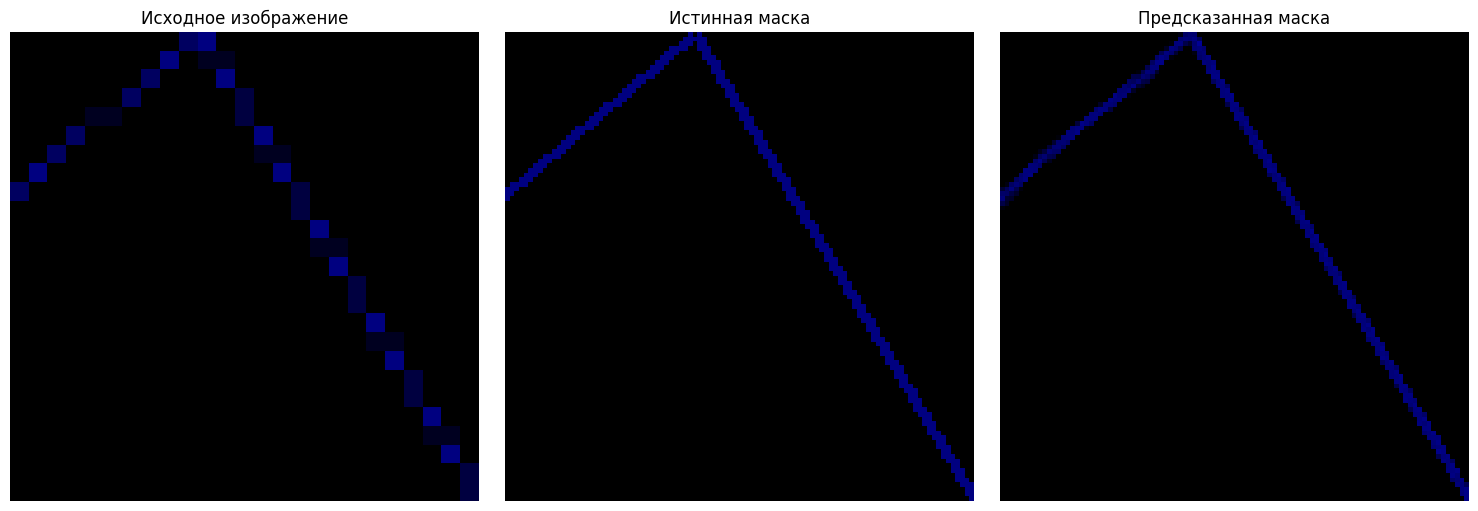

In [ ]:
x_train_img = x_train[0]
y_train_mask = y_train[0]
predicted_mask = pred[0]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x_train_img, cmap='gray')
axs[0].set_title('Исходное изображение')
axs[0].axis('off')

axs[1].imshow(y_train_mask, cmap='gray')
axs[1].set_title('Истинная маска')
axs[1].axis('off')

axs[2].imshow(predicted_mask, cmap='gray')
axs[2].set_title('Предсказанная маска')
axs[2].axis('off')

plt.tight_layout()
plt.show()